### Version History
+ Ver 1.0 : vgg net 구현
+ Ver 1.1 : encapsulation 및 refactoring 진행함

In [1]:
%matplotlib inline
!pip install tensorboardcolab

import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorboardcolab
from tensorflow.python.training import checkpoint_utils as cp

Using TensorFlow backend.


## Load Image Data set

In [0]:
def load_cifar10() :
    # load cifar10 dataset 
    from keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # reshape (None, 1) -> (None)
    y_train, y_test = [np.reshape(y_train, [-1]), np.reshape(y_test, [-1])]

    # normalization 
    x_train, x_test = [(x_train-x_train.max()) / (x_train.max()-x_train.min()),
                         (x_test-x_test.max()) / (x_test.max()-x_test.min())]

    temp = x_train
    ratio = int(len(x_train) * 0.7)
    ratio_end = int(len(x_train) * 1.0)  
    
    train_image = temp[0:ratio, :, :, :]
    valid_image = temp[ratio:ratio_end , :, :, :]
    
    train_label = y_train[0:ratio]
    valid_label = y_train[ratio:ratio_end ]
    
    return train_image, train_label, valid_image, valid_label, x_test, y_test

## Data Augmentation

In [0]:
def random_crop_and_pad(images, pad=4) :
    '''
    pad 크기만큼 무작위로 위아래, 좌우로 움직이는 메소드
    '''
    
    _, h, w, _ = images.shape
    pad_images = np.pad(images, [(0,0), (pad, pad), (pad, pad), (0,0)],
                         mode = 'constant')
    crops = []
    for idx, image in enumerate(pad_images) :
        start_y = np.random.randint(0, pad)
        start_x = np.random.radinit(0, pad)
        cropped = image[start_y:start_y+h, start_x:start_x+w]
        crops.append(cropped)
    return np.stack(crops)

def random_flip_left_right(images) :
    '''
    무작위로 이미지를 좌우로 뒤집어 주는 메소드
    '''
    
    for idx, image in enumerate(images) :
        if np.random.random() > 0.5 :
            images[idx] = images[:,::-1]
    return images

def random_rotate(image, max_angle=15) :
    '''
    최대 max angle내에서 이미지를 무작위로 회전시키는 메소드
    '''
    
    _, h, w, _ = images.shape
    
    for idx, images in enumerate(images) :
        angle = np.random.randint(-max_angle, max_angle)
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        images[idx] = cv2.warpAffine(image, M, w, h)
    return images

def random_brightness_correction(image, min_val=0.8, max_val=1.2) :
    '''
    무작위로 Brightness값을 바꿔주는 메소드
    '''
    
    results = []
    for image in images :
        value = np.random.uniform(min_val, max_val)
        image = cvv2.cvtCOlor(image, cv2.COLOR_RGB2RSV)
        results.append(image)
    return np.stack(result)

def augment_images(images) :
    '''
    평행이동 -> 뒤집기 -> 회전 -> 명도 변환을 거쳐 데이터에 노이즈를 주는 메소드
    '''
    
    images = random_crop_and_pad(images, pad=4)
    images = random_flip_left_right(images)
    images = random_rotate(images)
    images = random_brightness_correction(images)
    return images
    

## Data Provider

In [0]:
class DataProvider(object):
    def __init__(self, x, y):
        self.epoch_count = 0
        
        self.data = x
        self.label = y
        
        npr.seed(42)
        
        self.indices = self.generate_indices()
        
    def generate_indices(self):
        indices = list(range(len(self.data)))
        npr.shuffle(indices)
        
        return indices
    
    def next_batch(self, batch_size):
        idx = batch_size
        if len(self.indices) < batch_size:
            print("all data consumed, epoch + 1")
            self.epoch_count += 1
            self.indices = self.generate_indices()
    
        target_indices = self.indices[:batch_size]
        del self.indices[:batch_size]
        
        return self.data[target_indices] , self.label[target_indices]

In [0]:
def cifar_generator(data, labels, batch_size=32):
    start_idx = 0
    num_step = len(data) // batch_size
    indexes = np.arange(0, len(data))
    while True:
        if start_idx >= num_step-1:
            np.random.shuffle(indexes)
            start_idx = 0
        else:
            start_idx += 1            
        batch_index = indexes[start_idx*batch_size: (start_idx+1)*batch_size]

        batch_data = data[batch_index]
        batch_label = labels[batch_index]

        yield batch_data, batch_label

## Load pretrained variables

In [0]:
def get_trained_weights(graph, sess) :
    
    # loading pretrained files
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    !mkdir ./model
    !cp gdrive/My\ Drive/vgg/* model/ # from, to 임
    
    with graph.as_default() : 
        lode_dir = "./model/vgg_net_model_a"
        saver = tf.train.import_meta_graph(lode_dir + '.meta')
        saver.restore(sess, save_path = lode_dir)    
        
        reuse_vars = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
        # trained variable name : values
        reuse_vars_dict = dict([(var.name.replace(':0',''), sess.run(var.name)) 
                                for var in reuse_vars])
        return reuse_vars_dict       

## model functions

In [0]:
def conv2d_init(input, in_, out_, floor, is_train, model, name) :
             
    kernel_init = tf.random.normal(shape=[2, 2, in_, out_], 
                                   mean=0.0, stddev=0.1, dtype=tf.float32) 
    bias_init   = tf.zeros([out_])
    kernel      = tf.Variable(kernel_init, name = name+'_kernel'+str(floor))               
    bias        = tf.Variable(bias_init, name = name+'_bias'+str(floor))        
    layer       = tf.nn.conv2d(input, kernel, strides=[1,1,1,1], padding='SAME')
    layer       = layer + bias
    layer       = tf.nn.relu(layer)
    
    if model == "BN" :
        layer = tf.layers.BatchNormalization()(layer, training=is_train)
        
    return layer

In [0]:
def max_pooling2d(input) :
    pool  = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(input) 
    
    return pool

In [0]:
def fc_init(input, in_, out_, dr, is_train, model, name) :
    he_init     = tf.sqrt(2/out_) # tf.initializers.he_normal
    kernel_init = tf.random.normal(shape = [in_, out_], 
                                   mean=0.0, stddev=he_init, dtype = tf.float32)
    bias_init   = tf.zeros([out_])    
    kernel      = tf.Variable(kernel_init, name = name+"_kernel")
    bias        = tf.Variable(bias_init, name = name+"_bias")
    z           = tf.matmul(input, kernel) + bias 
    logits      = tf.nn.relu(z)
    
    if model == "BN" :
        logits = tf.layers.BatchNormalization()(logits, training=is_train)
    dropout     = tf.layers.Dropout(dr)(logits, training = is_train)
    
    return dropout  

In [0]:
def softmax_l2_with_loss(ys_true, ys_pred, weight_decay) :  
    sce_loss = tf.reduce_mean(
        tf.losses.sparse_softmax_cross_entropy(labels=ys_true, logits=ys_pred))
    l2_loss  = tf.add_n([tf.nn.l2_loss(var) for var in tf.global_variables()])
    loss     = sce_loss + weight_decay * l2_loss
    
    return loss

In [0]:
def accuracy(y_true, y_pred) :
    pred     = tf.cast(tf.arg_max(y_pred, 1), tf.int32)
    correct  = tf.equal(pred, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    # add tensor to tensorboard
    acc_tb   = tf.summary.scalar(name='accuracy', tensor=accuracy)
    
    return accuracy

## main model

In [0]:
graph = tf.Graph()

In [13]:
with graph.as_default() :
    xs       = tf.placeholder(tf.float32, (None, 32, 32, 3), name='xs') 
    ys       = tf.placeholder(tf.int32, (None), name='ys')
    lr       = tf.placeholder_with_default(0.001, (), name='lr')
    wd       = tf.placeholder_with_default(0.9, (), name='wd')
    is_train = tf.placeholder_with_default(False, (), name='is_train')
    m        = tf.placeholder_with_default(0.9, (), name='momentum')
    dr       = tf.placeholder_with_default(0.9, (), name='dropout_ratio')   
    model    = tf.placeholder_with_default("VGG", (), name='model')         
    # trained_dict = get_trained_weights(self.graph, self.sess)
    
    with tf.name_scope('VGGBlock-1') :
        layer = conv2d_init(xs, 3, 32, 1, is_train, model, 'conv1')
        # layer = conv2d(xs, trained_dict, is_train, 1, 'conv1')
        pool  = max_pooling2d(layer)   
        
    with tf.name_scope('VGGBlock-2') :
        layer = conv2d_init(pool, 32, 64, 1, is_train, model, 'conv2')
        pool  = max_pooling2d(layer)
        
    with tf.name_scope('VGGBlock-3') :
        layer = conv2d_init(pool, 64, 128, 1, is_train, model,'conv3')
        layer = conv2d_init(layer, 128, 128, 2, is_train, model,'conv3')
        pool = max_pooling2d(layer)
        
    with tf.name_scope('VGGBlock-4') :
        layer = conv2d_init(pool, 128, 256, 1, is_train, model,'conv4')
        layer = conv2d_init(layer, 256, 256, 2, is_train, model,'conv4')
        pool  = max_pooling2d(layer)
    
    with tf.name_scope('fc') : 
        flatten = tf.layers.flatten(pool)
        layer = fc_init(flatten, 1024, 1024, dr, is_train, model, 'fc1')    
        layer = fc_init(layer, 1024, 1024, dr, is_train, model,'fc2')                                 
        layer = fc_init(layer, 1024, 512, dr, is_train, model,'fc3')
    
    with tf.name_scope('output') : 
        y_pred  = tf.layers.Dense(10, 
                                  activation=None, 
                                  name='y_pred')(layer)     
    
    with tf.name_scope('Loss') :
        loss = softmax_l2_with_loss(ys, y_pred, wd)
    loss = tf.identity(loss, name='loss')
        
    with tf.name_scope('metric') :
        rmse = tf.sqrt(loss)
    rmse = tf.identity(rmse, name='rmse')
    
    with tf.name_scope('accuracy') :
        acc = accuracy(ys, y_pred)
    acc = tf.identity(acc, name='acc')

    with tf.name_scope('train') :
        optimizer   = tf.train.AdamOptimizer(lr)
        train_op    = optimizer.minimize(loss)

W0621 08:47:04.744468 139857247922048 deprecation.py:323] From <ipython-input-13-b9f5726226a1>:32: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0621 08:47:05.081440 139857247922048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0621 08:47:05.454206 139857247922048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has th

## pretrainingmodel

In [0]:
def model_a(config) :
    
    # load data    
    train_image, train_label, \
    valid_image, valid_label, \
    test_image, test_label = load_cifar10()
    
    # load hyper parameters
    model_type    = config['model_type']
    load_model    = config['load_model']
    save_model    = config['save_model']
    learning_rate = config['learning_rate']  
    batch_size    = config['batch_size']
    n_epoch       = config['epoch']
    n_step        = int(len(train_image) // batch_size)
    weight_decay  = config['weight_decay']
    dropout_ratio = config['dropout_ratio']
    
    # save directory 
    if load_model == None :
         lode_dir = None
    else :
         lode_dir = "./model/vgg_net_model_" + load_model  
    
    if save_model == None :
        save_dir = None
        log_dir = None
    else :
        save_dir = "./model/vgg_net_model_" + save_model  
        log_dir = "./log/vgg_net_model_" + save_model
    
    # graph = tf.Graph()
    with graph.as_default() :
        saver           = tf.train.Saver()    
        sess            = tf.Session()
        sess.run(tf.global_variables_initializer())
        
        # create Instance
        train_generator = cifar_generator(train_image, train_label, batch_size)
        
        train_loss = []
        train_acc = []
        valid_loss = []
        valid_acc = []
        cnt = 0
        maximum_acc = 0.5
        for i in tqdm(range(n_epoch)) :
            for step in range(n_step) :
                batch_xs, batch_ys = next(train_generator)
                _, train_loss_, train_acc_ = sess.run([train_op, rmse, acc], 
                                            feed_dict = { xs: batch_xs, 
                                                          ys: batch_ys, 
                                                          lr: learning_rate,
                                                          wd : weight_decay,
                                                          dr : dropout_ratio, 
                                                          model : model_type,  
                                                          is_train : True})
                train_loss.append(train_loss_)
                train_acc.append(train_acc_)
            
                # check validation set
                if step % 100 == 0 :
                    loss_, acc_ = sess.run([rmse, acc], 
                                          feed_dict = { xs: valid_image, 
                                                        ys: valid_label,
                                                        wd : weight_decay,
                                                        is_train : False})
                    valid_loss.append(loss_)
                    valid_acc.append(acc_)
                
                    # Save the model
                    if acc_ > maximum_acc :
                        print("log current model! valid loss = {:.4f}, valid acc = {:.2f}%".format(loss_, acc_*100))
                        maximum_acc = acc_
                        if save_model != None :
                            saver.save(sess, save_path = save_dir)
                        # w_name = graph.get_tensor_by_name('VGGBlock-1/conv1_kernel1:0')
                        # w = sess.run(w_name)
                        # print(w)
            print(" valid loss = {:.4f}, valid acc = {:.2f}%".format(loss_, acc_*100))
        
        
        #train_writer.flush() # file을 disk에 쓴다
    return valid_loss, valid_acc

In [0]:
def show_result(vgg_loss, vgg_acc, BN_loss, BN_acc) :
    plt.plot(vgg_acc, linestyle = "--", color = "red", label = "vgg_acc")
    plt.plot(BN_acc, linestyle = ":", color = "blue", label = "BN_acc")
    plt.legend()
    plt.show()
    
    plt.plot(vgg_loss, linestyle = "--", color = "red", label = "vgg_loss")
    plt.plot(BN_loss, linestyle = ":", color = "blue", label = "BN_loss")
    plt.legend()
    plt.show()

## main function

170500096/170498071 [==============================] - 2s 0us/step


  2%|▏         | 1/50 [00:09<07:44,  9.48s/it]

 valid loss = 2.4585, valid acc = 9.89%


  4%|▍         | 2/50 [00:12<06:02,  7.56s/it]

 valid loss = 2.1039, valid acc = 19.43%


  6%|▌         | 3/50 [00:15<04:52,  6.22s/it]

 valid loss = 1.9569, valid acc = 35.76%


  8%|▊         | 4/50 [00:18<04:02,  5.28s/it]

 valid loss = 1.8610, valid acc = 40.76%


 10%|█         | 5/50 [00:21<03:27,  4.62s/it]

 valid loss = 1.7885, valid acc = 46.15%
log current model! valid loss = 1.7071, valid acc = 51.87%


 12%|█▏        | 6/50 [00:25<03:05,  4.22s/it]

 valid loss = 1.7071, valid acc = 51.87%
log current model! valid loss = 1.6730, valid acc = 52.90%


 14%|█▍        | 7/50 [00:28<02:49,  3.94s/it]

 valid loss = 1.6730, valid acc = 52.90%
log current model! valid loss = 1.6457, valid acc = 53.43%


 16%|█▌        | 8/50 [00:31<02:37,  3.74s/it]

 valid loss = 1.6457, valid acc = 53.43%
log current model! valid loss = 1.5902, valid acc = 57.45%


 18%|█▊        | 9/50 [00:34<02:27,  3.60s/it]

 valid loss = 1.5902, valid acc = 57.45%
log current model! valid loss = 1.5487, valid acc = 59.11%


 20%|██        | 10/50 [00:38<02:20,  3.51s/it]

 valid loss = 1.5487, valid acc = 59.11%
log current model! valid loss = 1.5349, valid acc = 59.55%


 22%|██▏       | 11/50 [00:41<02:14,  3.44s/it]

 valid loss = 1.5349, valid acc = 59.55%
log current model! valid loss = 1.5070, valid acc = 60.47%


 24%|██▍       | 12/50 [00:44<02:09,  3.40s/it]

 valid loss = 1.5070, valid acc = 60.47%
log current model! valid loss = 1.4706, valid acc = 62.64%


 26%|██▌       | 13/50 [00:48<02:04,  3.37s/it]

 valid loss = 1.4706, valid acc = 62.64%


 28%|██▊       | 14/50 [00:51<01:59,  3.31s/it]

 valid loss = 1.4803, valid acc = 61.16%


 30%|███       | 15/50 [00:54<01:54,  3.28s/it]

 valid loss = 1.4552, valid acc = 62.06%


 32%|███▏      | 16/50 [00:57<01:50,  3.26s/it]

 valid loss = 1.4653, valid acc = 61.89%
log current model! valid loss = 1.4131, valid acc = 64.13%


 34%|███▍      | 17/50 [01:01<01:47,  3.27s/it]

 valid loss = 1.4131, valid acc = 64.13%
log current model! valid loss = 1.4164, valid acc = 64.89%


 36%|███▌      | 18/50 [01:04<01:45,  3.28s/it]

 valid loss = 1.4164, valid acc = 64.89%
log current model! valid loss = 1.4102, valid acc = 64.99%


 38%|███▊      | 19/50 [01:07<01:42,  3.29s/it]

 valid loss = 1.4102, valid acc = 64.99%


 40%|████      | 20/50 [01:10<01:37,  3.26s/it]

 valid loss = 1.4212, valid acc = 63.91%


 42%|████▏     | 21/50 [01:14<01:34,  3.25s/it]

 valid loss = 1.4350, valid acc = 63.89%
log current model! valid loss = 1.4059, valid acc = 65.34%


 44%|████▍     | 22/50 [01:17<01:31,  3.26s/it]

 valid loss = 1.4059, valid acc = 65.34%


 46%|████▌     | 23/50 [01:20<01:27,  3.24s/it]

 valid loss = 1.4341, valid acc = 64.16%
log current model! valid loss = 1.4139, valid acc = 65.67%


 48%|████▊     | 24/50 [01:23<01:24,  3.26s/it]

 valid loss = 1.4139, valid acc = 65.67%
log current model! valid loss = 1.4321, valid acc = 65.80%


 50%|█████     | 25/50 [01:27<01:21,  3.27s/it]

 valid loss = 1.4321, valid acc = 65.80%


 52%|█████▏    | 26/50 [01:30<01:17,  3.25s/it]

 valid loss = 1.4314, valid acc = 63.79%


 54%|█████▍    | 27/50 [01:33<01:14,  3.23s/it]

 valid loss = 1.4313, valid acc = 65.71%


 56%|█████▌    | 28/50 [01:36<01:10,  3.21s/it]

 valid loss = 1.4558, valid acc = 64.73%


 58%|█████▊    | 29/50 [01:39<01:07,  3.20s/it]

 valid loss = 1.4560, valid acc = 65.15%


 60%|██████    | 30/50 [01:43<01:04,  3.20s/it]

 valid loss = 1.4486, valid acc = 64.91%


 62%|██████▏   | 31/50 [01:46<01:00,  3.20s/it]

 valid loss = 1.4921, valid acc = 64.64%


 64%|██████▍   | 32/50 [01:49<00:57,  3.20s/it]

 valid loss = 1.5049, valid acc = 64.73%


 66%|██████▌   | 33/50 [01:52<00:54,  3.19s/it]

 valid loss = 1.5131, valid acc = 64.37%


 68%|██████▊   | 34/50 [01:55<00:50,  3.19s/it]

 valid loss = 1.5027, valid acc = 65.27%


 70%|███████   | 35/50 [01:58<00:47,  3.18s/it]

 valid loss = 1.4797, valid acc = 64.34%


 72%|███████▏  | 36/50 [02:02<00:44,  3.18s/it]

 valid loss = 1.4923, valid acc = 65.53%


 74%|███████▍  | 37/50 [02:05<00:41,  3.17s/it]

 valid loss = 1.5030, valid acc = 64.96%


 76%|███████▌  | 38/50 [02:08<00:38,  3.18s/it]

 valid loss = 1.5105, valid acc = 65.32%


 78%|███████▊  | 39/50 [02:11<00:34,  3.17s/it]

 valid loss = 1.4948, valid acc = 64.86%


 80%|████████  | 40/50 [02:14<00:31,  3.17s/it]

 valid loss = 1.4771, valid acc = 64.87%


 82%|████████▏ | 41/50 [02:17<00:28,  3.17s/it]

 valid loss = 1.4822, valid acc = 65.06%


 84%|████████▍ | 42/50 [02:21<00:25,  3.17s/it]

 valid loss = 1.4606, valid acc = 65.39%


 86%|████████▌ | 43/50 [02:24<00:22,  3.18s/it]

 valid loss = 1.5259, valid acc = 64.67%


 88%|████████▊ | 44/50 [02:27<00:19,  3.17s/it]

 valid loss = 1.5333, valid acc = 63.75%


 90%|█████████ | 45/50 [02:30<00:15,  3.18s/it]

 valid loss = 1.5044, valid acc = 64.87%
log current model! valid loss = 1.4808, valid acc = 65.90%


 92%|█████████▏| 46/50 [02:33<00:12,  3.21s/it]

 valid loss = 1.4808, valid acc = 65.90%
log current model! valid loss = 1.4987, valid acc = 66.12%


 94%|█████████▍| 47/50 [02:37<00:09,  3.24s/it]

 valid loss = 1.4987, valid acc = 66.12%


 96%|█████████▌| 48/50 [02:40<00:06,  3.22s/it]

 valid loss = 1.5035, valid acc = 65.76%


 98%|█████████▊| 49/50 [02:43<00:03,  3.21s/it]

 valid loss = 1.5543, valid acc = 63.57%


100%|██████████| 50/50 [02:46<00:00,  3.20s/it]

 valid loss = 1.4608, valid acc = 65.33%



  2%|▏         | 1/50 [00:03<02:49,  3.46s/it]

 valid loss = 2.5159, valid acc = 10.14%


  4%|▍         | 2/50 [00:06<02:41,  3.37s/it]

 valid loss = 2.0795, valid acc = 23.69%


  6%|▌         | 3/50 [00:09<02:35,  3.31s/it]

 valid loss = 1.9226, valid acc = 35.95%


  8%|▊         | 4/50 [00:12<02:30,  3.27s/it]

 valid loss = 1.8382, valid acc = 41.10%


 10%|█         | 5/50 [00:16<02:25,  3.24s/it]

 valid loss = 1.7521, valid acc = 46.74%
log current model! valid loss = 1.6960, valid acc = 50.58%


 12%|█▏        | 6/50 [00:19<02:21,  3.22s/it]

 valid loss = 1.6960, valid acc = 50.58%
log current model! valid loss = 1.6522, valid acc = 51.49%


 14%|█▍        | 7/50 [00:22<02:18,  3.21s/it]

 valid loss = 1.6522, valid acc = 51.49%
log current model! valid loss = 1.5962, valid acc = 55.09%


 16%|█▌        | 8/50 [00:25<02:14,  3.21s/it]

 valid loss = 1.5962, valid acc = 55.09%
log current model! valid loss = 1.5643, valid acc = 57.13%


 18%|█▊        | 9/50 [00:28<02:11,  3.21s/it]

 valid loss = 1.5643, valid acc = 57.13%
log current model! valid loss = 1.5399, valid acc = 57.82%


 20%|██        | 10/50 [00:32<02:08,  3.21s/it]

 valid loss = 1.5399, valid acc = 57.82%
log current model! valid loss = 1.4965, valid acc = 60.00%


 22%|██▏       | 11/50 [00:35<02:04,  3.20s/it]

 valid loss = 1.4965, valid acc = 60.00%


 24%|██▍       | 12/50 [00:38<02:01,  3.19s/it]

 valid loss = 1.4899, valid acc = 59.60%
log current model! valid loss = 1.4597, valid acc = 61.58%


 26%|██▌       | 13/50 [00:41<01:57,  3.19s/it]

 valid loss = 1.4597, valid acc = 61.58%
log current model! valid loss = 1.4352, valid acc = 63.07%


 28%|██▊       | 14/50 [00:44<01:54,  3.19s/it]

 valid loss = 1.4352, valid acc = 63.07%


 30%|███       | 15/50 [00:48<01:51,  3.19s/it]

 valid loss = 1.4206, valid acc = 62.95%
log current model! valid loss = 1.3904, valid acc = 64.77%


 32%|███▏      | 16/50 [00:51<01:48,  3.18s/it]

 valid loss = 1.3904, valid acc = 64.77%


 34%|███▍      | 17/50 [00:54<01:45,  3.18s/it]

 valid loss = 1.3895, valid acc = 64.73%


 36%|███▌      | 18/50 [00:57<01:41,  3.18s/it]

 valid loss = 1.3887, valid acc = 64.29%
log current model! valid loss = 1.3724, valid acc = 65.64%


 38%|███▊      | 19/50 [01:00<01:38,  3.18s/it]

 valid loss = 1.3724, valid acc = 65.64%
log current model! valid loss = 1.3543, valid acc = 66.16%


 40%|████      | 20/50 [01:03<01:35,  3.18s/it]

 valid loss = 1.3543, valid acc = 66.16%


 42%|████▏     | 21/50 [01:07<01:32,  3.18s/it]

 valid loss = 1.3722, valid acc = 65.41%
log current model! valid loss = 1.3672, valid acc = 66.66%


 44%|████▍     | 22/50 [01:10<01:29,  3.18s/it]

 valid loss = 1.3672, valid acc = 66.66%


 46%|████▌     | 23/50 [01:13<01:25,  3.18s/it]

 valid loss = 1.3654, valid acc = 66.00%


 48%|████▊     | 24/50 [01:16<01:22,  3.18s/it]

 valid loss = 1.3758, valid acc = 66.39%


 50%|█████     | 25/50 [01:19<01:19,  3.18s/it]

 valid loss = 1.3670, valid acc = 66.60%
log current model! valid loss = 1.3661, valid acc = 67.00%


 52%|█████▏    | 26/50 [01:22<01:16,  3.18s/it]

 valid loss = 1.3661, valid acc = 67.00%


 54%|█████▍    | 27/50 [01:26<01:13,  3.19s/it]

 valid loss = 1.4048, valid acc = 66.07%


 56%|█████▌    | 28/50 [01:29<01:10,  3.19s/it]

 valid loss = 1.4105, valid acc = 66.14%


 58%|█████▊    | 29/50 [01:32<01:06,  3.19s/it]

 valid loss = 1.4042, valid acc = 65.65%


 60%|██████    | 30/50 [01:35<01:03,  3.19s/it]

 valid loss = 1.4120, valid acc = 66.15%


 62%|██████▏   | 31/50 [01:38<01:00,  3.19s/it]

 valid loss = 1.4074, valid acc = 66.75%


 64%|██████▍   | 32/50 [01:42<00:57,  3.19s/it]

 valid loss = 1.4290, valid acc = 66.45%


 66%|██████▌   | 33/50 [01:45<00:54,  3.19s/it]

 valid loss = 1.4921, valid acc = 63.48%


 68%|██████▊   | 34/50 [01:48<00:51,  3.19s/it]

 valid loss = 1.4640, valid acc = 66.28%


 70%|███████   | 35/50 [01:51<00:47,  3.19s/it]

 valid loss = 1.4389, valid acc = 66.57%


 72%|███████▏  | 36/50 [01:54<00:44,  3.19s/it]

 valid loss = 1.4575, valid acc = 66.69%


 74%|███████▍  | 37/50 [01:58<00:41,  3.20s/it]

 valid loss = 1.4354, valid acc = 66.75%


 76%|███████▌  | 38/50 [02:01<00:38,  3.19s/it]

 valid loss = 1.4792, valid acc = 65.82%


 78%|███████▊  | 39/50 [02:04<00:35,  3.20s/it]

 valid loss = 1.4424, valid acc = 66.03%


 80%|████████  | 40/50 [02:07<00:31,  3.20s/it]

 valid loss = 1.4403, valid acc = 65.49%


 82%|████████▏ | 41/50 [02:10<00:28,  3.20s/it]

 valid loss = 1.4386, valid acc = 66.27%


 84%|████████▍ | 42/50 [02:14<00:25,  3.20s/it]

 valid loss = 1.4943, valid acc = 65.23%


 86%|████████▌ | 43/50 [02:17<00:22,  3.20s/it]

 valid loss = 1.4599, valid acc = 66.54%


 88%|████████▊ | 44/50 [02:20<00:19,  3.20s/it]

 valid loss = 1.4706, valid acc = 65.64%


 90%|█████████ | 45/50 [02:23<00:15,  3.20s/it]

 valid loss = 1.4805, valid acc = 66.49%


 92%|█████████▏| 46/50 [02:26<00:12,  3.20s/it]

 valid loss = 1.4853, valid acc = 65.60%


 94%|█████████▍| 47/50 [02:30<00:09,  3.20s/it]

 valid loss = 1.4712, valid acc = 66.91%


 96%|█████████▌| 48/50 [02:33<00:06,  3.20s/it]

 valid loss = 1.4580, valid acc = 66.83%


 98%|█████████▊| 49/50 [02:36<00:03,  3.20s/it]

 valid loss = 1.4771, valid acc = 66.62%


100%|██████████| 50/50 [02:39<00:00,  3.20s/it]

 valid loss = 1.4794, valid acc = 67.00%


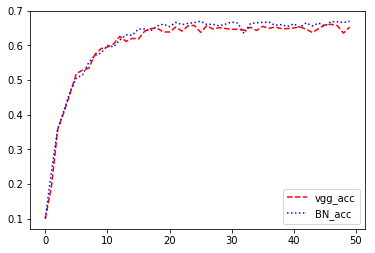

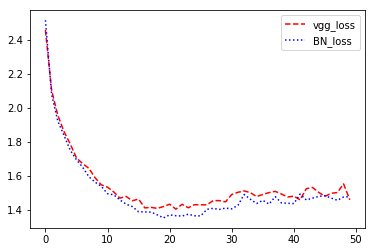

In [16]:
def main() :
    
    # config of hyper parameters
    config = {
        "model_type"      : "VGG",  # VGG or BN
        "load_model"      : None,
        "save_model"      : "a",
        "learning_rate"   : 0.001,
        "batch_size"      : 1000,
        "epoch"           : 50,
        "weight_decay"    : 0.0005,
        "dropout_ratio"   : 0.5
    }
    
    # call reconstruct model
    vgg_loss, vgg_acc = model_a(config)
    
    
    # config of hyper parameters
    config = {
        "model_type"      : "BN",  # VGG or BN
        "load_model"      : None,
        "save_model"      : None,
        "learning_rate"   : 0.001,
        "batch_size"      : 1000,
        "epoch"           : 50,
        "weight_decay"    : 0.0005,
        # Cifa10 Dataset은 overfitting이 심하기 때문에 dropout을 제거하는 대신 비율을 줄임
        "dropout_ratio"   : 0.4 
    }
    
    BN_loss, BN_acc = model_a(config)

    show_result(vgg_loss, vgg_acc, BN_loss, BN_acc)
    
if __name__ == '__main__':
    main()           

## save model

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir gdrive/My\ Drive/vgg
!mv ./model/vgg* gdrive/My\ Drive/vgg
!mv ./model/checkpoint gdrive/My\ Drive/vgg

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
mkdir: cannot create directory ‘gdrive/My Drive/vgg’: File exists
